<cite>Darryl Oatridge, August 2022<cite>

In [49]:
import os

In [50]:
os.environ['HADRON_PM_PATH'] = '0_hello_meta/demo/contracts'
os.environ['HADRON_DEFAULT_PATH'] = '0_hello_meta/demo/data'

## Feature Engineering
In the previous section we built the first component to cover selection with the second component we are going to deal  with Feature engineering.  We have now identified the features of interest and now want to tidy those features So they are more compliant to a machine learning model or further feature investigation. 

For feature engineering we are going to use the wrangle component and as before create a new contract.

In [51]:
from ds_discovery import Wrangle, Transition

In [52]:
# get the instance
wr = Wrangle.from_env('hello_wr', has_contract=False)

As this is a new component we need to set the source and the persist but in this case we want the source to be the outcome of the previous component. As this is a common thing to do there is a First class method call `get_persist_contract` that can be called directly.  We create an instance of the Transistion component giving it its unique name and then call the method that retrieves a copy of that components persist Connector Contract, this we then set as the source.

In [53]:
source = Transition.from_env('hello_tr').get_persist_contract()
wr.set_source_contract(source)
wr.set_persist()

As a check we can run the canonical report and see that we have loaded the output of the previous component (Transition component) into the current source.  



In [54]:
df = wr.load_source_canonical()

In [55]:
wr.canonical_report(df)

,Attributes (10),dType,%_Null,%_Dom,Count,Unique,Observations
0,age,float64,20.1%,20.1%,1309,99,max=80.0 | min=0.1667 | mean=29.88 | dominant=24.0
1,cabin,string,77.5%,77.5%,1309,187,Sample: C23 C25 C27 | G6 | B57 B59 B63 B66 | F4 | F33
2,embarked,category,0.0%,69.8%,1309,4,Sample: S | C | Q | nan
3,fare,float64,0.1%,4.6%,1309,282,max=512.3292 | min=0.0 | mean=33.3 | dominant=8.05
4,parch,category,0.0%,76.5%,1309,8,Sample: 0 | 1 | 2 | 3 | 4
5,pclass,category,0.0%,54.2%,1309,3,Sample: 3 | 1 | 2
6,sex,category,0.0%,64.4%,1309,2,Sample: male | female
7,sibsp,category,0.0%,68.1%,1309,7,Sample: 0 | 1 | 2 | 4 | 3
8,survived,category,0.0%,61.8%,1309,2,Sample: 0 | 1
9,ticket,string,0.0%,0.8%,1309,929,Sample: CA. 2343 | 1601 | CA 2144 | PC 17608 | 347077


Now we have the source we can deal with the feature Engineering. As this is for the purpose of demonstration we are only sampling a small selection of Intent methods. It is well worth looking through the other Intent methods to get to know the full extent of the feature engineering package.

To get started, the column name `sibsip`, the number of siblings or the spouse of a person onboard, and `parch`, the number of parents or children each passenger was touring with, added together provide a new value that provides the size of each family.

In [56]:
df['family'] = wr.tools.correlate_aggregate(df, headers=['parch', 'sibsp'], agg='sum', column_name='family')

The column name `cabin` provides us with a record of the cabin each passenger was allocated.  Taking the first letter from each cabin gives us the deck the passenger was on. This provides us with a useful catagorical. 

In [57]:
df['deck'] = wr.tools.correlate_custom(df, code_str="@['cabin'].str[0]", column_name='deck')

We also note that a passenger travelling alone seems to have an improved survival rate. By selecting `family`, who's value is one and giving all other values a zero we can create a new column `is_alone` that indicates passengers travelling on their own.

In [58]:
selection = [wr.tools.select2dict(column='family', condition='@==0')]
df['is_alone'] = wr.tools.correlate_selection(df, selection=selection, action=1, default_action=0, column_name='is_alone')

Finally we ensure each of our new features are appropriately `typed` as a category. We also want to ensure the change to catagory runs after the newly created columns so we add the parameter `intent_order` with a value of one.

In [59]:
df = wr.tools.model_to_category(df, headers=['family','deck','is_alone'], intent_order=1, column_name='to_category')

By running the Intent report we can observe the change of order of the intent level.

In [60]:
wr.report_intent()

,level,order,intent,parameters,creator
0,deck,0,correlate_custom,"[""code_str='@['cabin'].str[0]'"", ""column_name='deck'"", 'kwargs={}']",doatridge
1,family,0,correlate_aggregate,"[""headers=['parch', 'sibsp']"", ""agg='sum'"", ""column_name='family'""]",doatridge
2,is_alone,0,correlate_selection,"[""selection=[{'column': 'family', 'condition': '@==0'}]"", 'action=1', 'default_action=0', ""column_name='is_alone'""]",doatridge
3,to_category,1,model_to_category,"[""headers=['family', 'deck', 'is_alone']"", ""column_name='to_category'""]",doatridge


## Component Pipeline

At this point we can run the pipeline and see the results of the new features.

In [61]:
wr.run_component_pipeline()

In [62]:
wr.canonical_report(df)

,Attributes (13),dType,%_Null,%_Dom,Count,Unique,Observations
0,age,float64,20.1%,20.1%,1309,99,max=80.0 | min=0.1667 | mean=29.88 | dominant=24.0
1,cabin,string,77.5%,77.5%,1309,187,Sample: C23 C25 C27 | G6 | B57 B59 B63 B66 | F4 | F33
2,deck,category,0.0%,77.5%,1309,9,Sample: | C | B | D | E
3,embarked,category,0.0%,69.8%,1309,4,Sample: S | C | Q | nan
4,family,category,0.0%,60.4%,1309,9,Sample: 0 | 1 | 2 | 3 | 5
5,fare,float64,0.1%,4.6%,1309,282,max=512.3292 | min=0.0 | mean=33.3 | dominant=8.05
6,is_alone,category,0.0%,60.4%,1309,2,Sample: 1 | 0
7,parch,category,0.0%,76.5%,1309,8,Sample: 0 | 1 | 2 | 3 | 4
8,pclass,category,0.0%,54.2%,1309,3,Sample: 3 | 1 | 2
9,sex,category,0.0%,64.4%,1309,2,Sample: male | female


## Imputation
Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a complete dataset that can be used to train machine learning models.  There are three types of missing data:
- Missing Completely at Random (MCAR); where the missing data has nothing to do with another feature(s)
- Missing at Random (MAR); where missing data can be interpreted from another feature(s)
- Missing not at Random (MNAR); where missing data is not random and can be interpreted from another feature(s)

With `deck` and `fair` we can assume MCAR but with `age` it appears to have association with other features.  But for the purposes of the demo we are going to assume it to also be MCAR.

With `deck` the conversion to catagorical has already imputed the nulls with the new catagorical value <NA> therefore we do not need to do anything. 

In [63]:
df['deck'].value_counts()

<NA>    1014
C         94
B         65
D         46
E         41
A         22
F         21
G          5
T          1
Name: deck, dtype: int64

With `fare`  we chose a random number whereby this number is more likely to fall within a populated area and preserves the distribution of the data. This works particulary well with the small amount of missing data. 

In [64]:
df['fare'] = wr.tools.correlate_missing(df, header='fare', method='random', column_name='fare')

We can see from the graphical representation of the data the data distribution is preserved.  

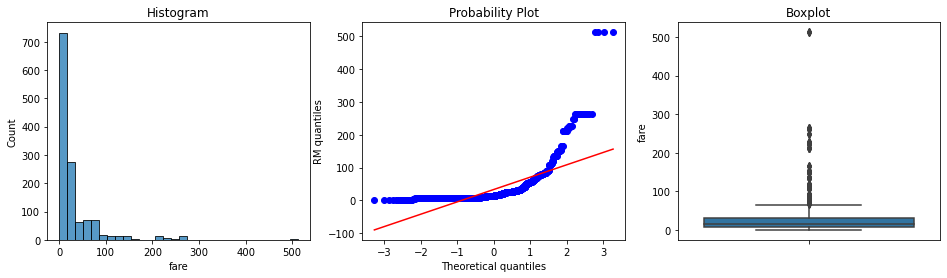

<Figure size 432x288 with 0 Axes>

In [65]:
wr.visual.show_distribution(df, 'fare')

Age is slightly more tricky as its null values are quite large.  In this instance we will use probability frequency, which like random values preserves the distribution of the data.  Quite often, in these cases, we can add an additional boulean column that tells us which values were generated to replace nulls.

In [67]:
df['age'] = wr.tools.correlate_missing_weighted(df, header='age', granularity=5.0, column_name='age')

Using the visual tools we can see the preservation of the data distribution whilst replacing nulls.

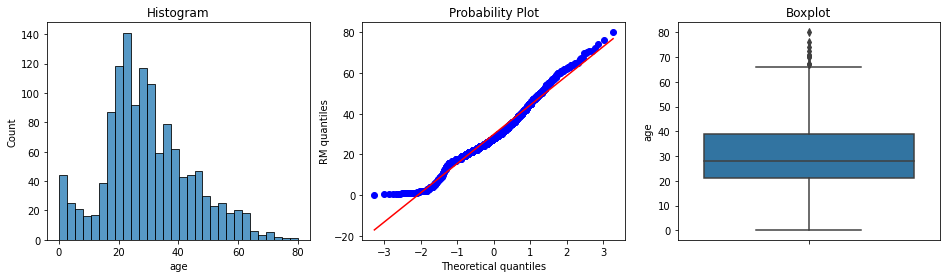

<Figure size 432x288 with 0 Axes>

In [68]:
wr.visual.show_distribution(df, 'age')

Using the Intent report we can check on the additional intent added.

In [69]:
wr.report_intent()

,level,order,intent,parameters,creator
0,age,0,correlate_missing_weighted,"[""header='age'"", 'granularity=5.0', ""column_name='age'""]",doatridge
1,deck,0,correlate_custom,"[""code_str='@['cabin'].str[0]'"", ""column_name='deck'"", 'kwargs={}']",doatridge
2,family,0,correlate_aggregate,"[""headers=['parch', 'sibsp']"", ""agg='sum'"", ""column_name='family'""]",doatridge
3,fare,0,correlate_missing,"[""header='fare'"", ""method='random'"", ""column_name='fare'""]",doatridge
4,is_alone,0,correlate_selection,"[""selection=[{'column': 'family', 'condition': '@==0'}]"", 'action=1', 'default_action=0', ""column_name='is_alone'""]",doatridge
5,to_category,1,model_to_category,"[""headers=['family', 'deck', 'is_alone']"", ""column_name='to_category'""]",doatridge


### Run Book

We have touched on Run Book before where by the Run Book allows us to define a run order that is preserved longer term.  With the need for `to_category` to run as the final intent the Run Book fulfills this perfectly.

Adding a Run Book is a simple task of listing the intent in the order in which you wish it to run.  As discussed before we are using the default Run Book which will automatically be picked up by the run component as its run order.

In [70]:
wr.add_run_book(run_levels=['age','deck','family','fare','is_alone','to_category'])

In [72]:
wr.run_component_pipeline()

Finially we can finish off by checking the Run Book with the Run Book report and produce the Canonical Report to see the changes the feature engineering has made.

In [71]:
wr.report_run_book()

,name,run_book
0,primary_run_book,"['age', 'deck', 'family', 'fare', 'is_alone', 'to_category']"


In [73]:
wr.canonical_report(wr.load_persist_canonical())

,Attributes (13),dType,%_Null,%_Dom,Count,Unique,Observations
0,age,float64,0.0%,3.6%,1309,361,max=80.0 | min=0.1667 | mean=29.91 | dominant=24.0
1,cabin,string,77.5%,77.5%,1309,187,Sample: C23 C25 C27 | G6 | B57 B59 B63 B66 | F4 | F33
2,deck,category,0.0%,77.5%,1309,9,Sample: | C | B | D | E
3,embarked,category,0.0%,69.8%,1309,4,Sample: S | C | Q | nan
4,family,category,0.0%,60.4%,1309,9,Sample: 0 | 1 | 2 | 3 | 5
5,fare,float64,0.0%,4.6%,1309,281,max=512.3292 | min=0.0 | mean=33.28 | dominant=8.05
6,is_alone,category,0.0%,60.4%,1309,2,Sample: 1 | 0
7,parch,category,0.0%,76.5%,1309,8,Sample: 0 | 1 | 2 | 3 | 4
8,pclass,category,0.0%,54.2%,1309,3,Sample: 3 | 1 | 2
9,sex,category,0.0%,64.4%,1309,2,Sample: male | female
